In [2]:
%load_ext autoreload

In [3]:
%autoreload 
from pandas_dq import dq_report, Fix_DQ, dc_report
import utilities as ut
import pandas as pd
import seaborn as sns

In [4]:
# Read and structure all the parquet files in the data folder
data_list = ut.read_data()
# Create a data processor object
Data = ut.DataProcessor(data_list)
# Create the formatted dataframe
df = Data.create_train_data()

(405151, 56)


# Analyse dataset

In [5]:
dqr = dq_report(df, target='pv_measurement', csv_engine='pandas', html=False, verbose=1)

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
absolute_humidity_2m:gm3,float32,0.000000,0,0.500000,18.900000,No issue
air_density_2m:kgm3,float32,0.000000,0,1.139000,1.441000,No issue
ceiling_height_agl:m,float32,18.054009,19,nan,nan,"73146 missing values. Impute them with mean, median, mode, or a constant value such as 123."
clear_sky_energy_1h:J,float32,0.000000,51,0.000000,3007721.500000,No issue
clear_sky_rad:W,float32,0.000000,2,0.000000,837.000000,No issue
cloud_base_agl:m,float32,7.629748,14,nan,nan,"30912 missing values. Impute them with mean, median, mode, or a constant value such as 123."
dew_or_rime:idx,float32,0.000000,0,-1.000000,1.000000,No issue
dew_point_2m:K,float32,0.000000,0,247.300003,295.100006,No issue
diffuse_rad:W,float32,0.000000,0,0.000000,345.700012,No issue
diffuse_rad_1h:J,float32,0.000000,51,0.000000,1217465.375000,No issue


small summary:

In [6]:
_ = dq_report(df, target='pv_measurement', verbose=0)

This is a summary report. Change verbose to 1 to see more details on each DQ issue.


,DQ Issue
The Good News,"There are no duplicate rows in this dataset, There are no duplicate columns in this datatset, There are no ID columns in the dataset. So no ID columns to remove before modeling., There are no categorical columns with rare categories (< 1 percent) in this dataset, There are no columns with infinite values in this dataset , There are no columns with mixed (more than one) dataypes in this dataset, There are no high cardinality columns in this dataset, There are no target leakage columns in the dataset"
The Bad News,"There are zero-variance columns in the dataset. Recommend removing them before modeling., There are 11 numerical columns, some with outliers. Remove them or use robust statistics., There are 3 columns with >= 0.8 correlation in the dataset. Drop one of them or use dimensionality reduction techniques."


# Compare dataset with test data

In [7]:
X_test = Data.create_test_data()

In [8]:
dc_report = dc_report(df, X_test, exclude=['pv_measurement'], html=False, verbose=1)

Analyzing two dataframes for differences. This will take time, please be patient...


,Column Name,Data Type_Train,Missing Values%_Train,Unique Values%_Train,Minimum Value_Train,Maximum Value_Train,DQ Issue_Train,Data Type_Test,Missing Values%_Test,Unique Values%_Test,Minimum Value_Test,Maximum Value_Test,DQ Issue_Test,Distribution Difference
0,absolute_humidity_2m:gm3,float32,0.000000,0,0.500000,18.900000,No issue,float32,0.000000,1,3.200000,14.200000,No issue,The percentage of unique values of absolute_humidity_2m:gm3 are different between train (0.00%) and test (1.00%).
1,air_density_2m:kgm3,float32,0.000000,0,1.139000,1.441000,No issue,float32,0.000000,1,1.142000,1.301000,No issue,The percentage of unique values of air_density_2m:kgm3 are different between train (0.00%) and test (1.00%).
2,ceiling_height_agl:m,float32,18.054009,19,nan,nan,"73146 missing values. Impute them with mean, median, mode, or a constant value such as 123.",float32,27.743056,57,nan,nan,"2397 missing values. Impute them with mean, median, mode, or a constant value such as 123.",The percentage of missing values of ceiling_height_agl:m are different between train (18.05%) and test (27.74%). The percentage of unique values of ceiling_height_agl:m are different between train (19.00%) and test (57.00%).
3,clear_sky_energy_1h:J,float32,0.000000,51,0.000000,3007721.500000,No issue,float32,0.000000,83,0.000000,3007376.250000,No issue,The percentage of unique values of clear_sky_energy_1h:J are different between train (51.00%) and test (83.00%).
4,clear_sky_rad:W,float32,0.000000,2,0.000000,837.000000,No issue,float32,0.000000,38,0.000000,836.900024,No issue,The percentage of unique values of clear_sky_rad:W are different between train (2.00%) and test (38.00%).
5,cloud_base_agl:m,float32,7.629748,14,nan,nan,"30912 missing values. Impute them with mean, median, mode, or a constant value such as 123.",float32,10.995370,72,nan,nan,"950 missing values. Impute them with mean, median, mode, or a constant value such as 123.",The percentage of missing values of cloud_base_agl:m are different between train (7.63%) and test (11.00%). The percentage of unique values of cloud_base_agl:m are different between train (14.00%) and test (72.00%).
6,dew_or_rime:idx,float32,0.000000,0,-1.000000,1.000000,No issue,float32,0.000000,0,-1.000000,1.000000,No issue,The distributions of dew_or_rime:idx are different with a KS test statistic of 0.030.
7,dew_point_2m:K,float32,0.000000,0,247.300003,295.100006,No issue,float32,0.000000,2,268.000000,290.200012,No issue,The percentage of unique values of dew_point_2m:K are different between train (0.00%) and test (2.00%).
8,diffuse_rad:W,float32,0.000000,0,0.000000,345.700012,No issue,float32,0.000000,26,0.000000,321.899994,No issue,The percentage of unique values of diffuse_rad:W are different between train (0.00%) and test (26.00%).
9,diffuse_rad_1h:J,float32,0.000000,51,0.000000,1217465.375000,No issue,float32,0.000000,83,0.000000,1116878.750000,No issue,The percentage of unique values of diffuse_rad_1h:J are different between train (51.00%) and test (83.00%).


## Remove some features based on the reports

In [9]:
drop_features = ['day_of_month', 'snow_density:kgm3', 'cloud_base_agl:m']
# drop the features in drop_features list
df = df.drop(drop_features, axis=1)
X_test = X_test.drop(drop_features, axis=1)

# Fix dataset quality issues using scikit-learn

It can remove ID columns, zero-variance columns, rare categories, infinite values, mixed data types, outliers, high cardinality features, highly correlated features, duplicate rows and columns, skewed distributions and imbalanced classes.

In [10]:
X_train = df.drop('pv_measurement', axis=1)

See that snow_depth:cm, snow_drift:idx and snow_melt_10min:mm has zero variance and therefore are of little interest

In [11]:
# drop snow_depth:cm, snow_drift:idx and snow_melt_10min:mm form X_train_transformed and X_test_transformed
X_train = X_train.drop(columns=['snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm'])
X_test = X_test.drop(columns=['snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm'])

In [12]:
_ = dq_report(X_test, verbose=1)

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
absolute_humidity_2m:gm3,float32,0.000000,1,3.200000,14.200000,No issue
air_density_2m:kgm3,float32,0.000000,1,1.142000,1.301000,No issue
ceiling_height_agl:m,float32,27.743056,57,nan,nan,"2397 missing values. Impute them with mean, median, mode, or a constant value such as 123."
clear_sky_energy_1h:J,float32,0.000000,83,0.000000,3007376.250000,No issue
clear_sky_rad:W,float32,0.000000,38,0.000000,836.900024,No issue
dew_or_rime:idx,float32,0.000000,0,-1.000000,1.000000,No issue
dew_point_2m:K,float32,0.000000,2,268.000000,290.200012,No issue
diffuse_rad:W,float32,0.000000,26,0.000000,321.899994,No issue
diffuse_rad_1h:J,float32,0.000000,83,0.000000,1116878.750000,No issue
direct_rad:W,float32,0.000000,30,0.000000,668.400024,No issue


In [13]:
_ = dq_report(X_train, verbose=1)

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
absolute_humidity_2m:gm3,float32,0.000000,0,0.500000,18.900000,No issue
air_density_2m:kgm3,float32,0.000000,0,1.139000,1.441000,No issue
ceiling_height_agl:m,float32,18.054009,19,nan,nan,"73146 missing values. Impute them with mean, median, mode, or a constant value such as 123."
clear_sky_energy_1h:J,float32,0.000000,51,0.000000,3007721.500000,No issue
clear_sky_rad:W,float32,0.000000,2,0.000000,837.000000,No issue
dew_or_rime:idx,float32,0.000000,0,-1.000000,1.000000,No issue
dew_point_2m:K,float32,0.000000,0,247.300003,295.100006,No issue
diffuse_rad:W,float32,0.000000,0,0.000000,345.700012,No issue
diffuse_rad_1h:J,float32,0.000000,51,0.000000,1217465.375000,No issue
direct_rad:W,float32,0.000000,1,0.000000,689.799988,No issue


Still missing some data in cloud ceiling, trying to impyte it using the mean

In [14]:
# impute missing values for ceiling_height_agl:m in X_train_transformed and X_test_transformed with the mean
X_train['ceiling_height_agl:m'] = X_train['ceiling_height_agl:m'].fillna(X_train['ceiling_height_agl:m'].mean())
X_test['ceiling_height_agl:m'] = X_test['ceiling_height_agl:m'].fillna(X_train['ceiling_height_agl:m'].mean())

In [15]:
_ = dq_report(X_test, verbose=1)

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
absolute_humidity_2m:gm3,float32,0.000000,1,3.200000,14.200000,No issue
air_density_2m:kgm3,float32,0.000000,1,1.142000,1.301000,No issue
ceiling_height_agl:m,float32,0.000000,57,30.600000,11468.000000,No issue
clear_sky_energy_1h:J,float32,0.000000,83,0.000000,3007376.250000,No issue
clear_sky_rad:W,float32,0.000000,38,0.000000,836.900024,No issue
dew_or_rime:idx,float32,0.000000,0,-1.000000,1.000000,No issue
dew_point_2m:K,float32,0.000000,2,268.000000,290.200012,No issue
diffuse_rad:W,float32,0.000000,26,0.000000,321.899994,No issue
diffuse_rad_1h:J,float32,0.000000,83,0.000000,1116878.750000,No issue
direct_rad:W,float32,0.000000,30,0.000000,668.400024,No issue


In [16]:
_ = dq_report(X_train, verbose=1)

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
absolute_humidity_2m:gm3,float32,0.000000,0,0.500000,18.900000,No issue
air_density_2m:kgm3,float32,0.000000,0,1.139000,1.441000,No issue
ceiling_height_agl:m,float32,0.000000,19,27.600000,12431.299805,No issue
clear_sky_energy_1h:J,float32,0.000000,51,0.000000,3007721.500000,No issue
clear_sky_rad:W,float32,0.000000,2,0.000000,837.000000,No issue
dew_or_rime:idx,float32,0.000000,0,-1.000000,1.000000,No issue
dew_point_2m:K,float32,0.000000,0,247.300003,295.100006,No issue
diffuse_rad:W,float32,0.000000,0,0.000000,345.700012,No issue
diffuse_rad_1h:J,float32,0.000000,51,0.000000,1217465.375000,No issue
direct_rad:W,float32,0.000000,1,0.000000,689.799988,No issue


In [17]:
df = pd.concat([X_train, df['pv_measurement']], axis=1)

In [18]:
_ = dq_report(df, verbose=1)

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
absolute_humidity_2m:gm3,float32,0.000000,0,0.500000,18.900000,No issue
air_density_2m:kgm3,float32,0.000000,0,1.139000,1.441000,No issue
ceiling_height_agl:m,float32,0.000000,19,27.600000,12431.299805,No issue
clear_sky_energy_1h:J,float32,0.000000,51,0.000000,3007721.500000,No issue
clear_sky_rad:W,float32,0.000000,2,0.000000,837.000000,No issue
dew_or_rime:idx,float32,0.000000,0,-1.000000,1.000000,No issue
dew_point_2m:K,float32,0.000000,0,247.300003,295.100006,No issue
diffuse_rad:W,float32,0.000000,0,0.000000,345.700012,No issue
diffuse_rad_1h:J,float32,0.000000,51,0.000000,1217465.375000,No issue
direct_rad:W,float32,0.000000,1,0.000000,689.799988,No issue


In [19]:
df.index

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 00:00:00',
               '2019-01-01 00:15:00', '2019-01-01 00:15:00',
               '2019-01-01 00:30:00', '2019-01-01 00:30:00',
               '2019-01-01 00:45:00', '2019-01-01 00:45:00',
               '2019-01-01 01:00:00', '2019-01-01 01:00:00',
               ...
               '2023-04-30 23:00:00', '2023-04-30 23:15:00',
               '2023-04-30 23:15:00', '2023-04-30 23:15:00',
               '2023-04-30 23:30:00', '2023-04-30 23:30:00',
               '2023-04-30 23:30:00', '2023-04-30 23:45:00',
               '2023-04-30 23:45:00', '2023-04-30 23:45:00'],
              dtype='datetime64[ns]', name='date_forecast', length=405151, freq=None)

#### Since we have weather data every 15 min but pv measurement every 60 we will try to interpolate the values to fill the gaps

In [20]:
df['pv_measurement'] = df['pv_measurement'].interpolate(method='linear', limit_direction='both')

/home/henrikraa/anaconda3/envs/pandas_dq/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pv_measurement', ylabel='Density'>

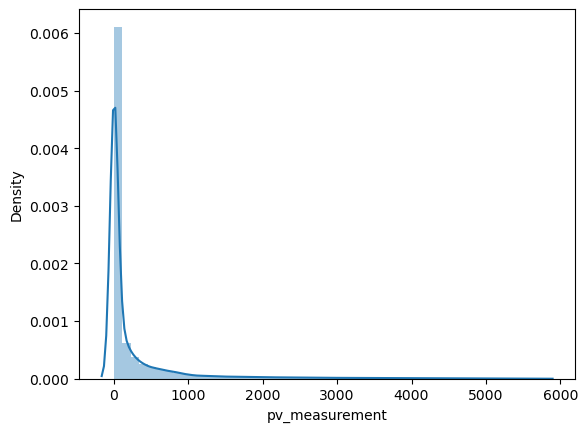

In [21]:
# plot the distribution of pv_measurement
sns.distplot(df['pv_measurement'])

In [22]:
_ = dq_report(df, verbose=1)

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
absolute_humidity_2m:gm3,float32,0.000000,0,0.500000,18.900000,No issue
air_density_2m:kgm3,float32,0.000000,0,1.139000,1.441000,No issue
ceiling_height_agl:m,float32,0.000000,19,27.600000,12431.299805,No issue
clear_sky_energy_1h:J,float32,0.000000,51,0.000000,3007721.500000,No issue
clear_sky_rad:W,float32,0.000000,2,0.000000,837.000000,No issue
dew_or_rime:idx,float32,0.000000,0,-1.000000,1.000000,No issue
dew_point_2m:K,float32,0.000000,0,247.300003,295.100006,No issue
diffuse_rad:W,float32,0.000000,0,0.000000,345.700012,No issue
diffuse_rad_1h:J,float32,0.000000,51,0.000000,1217465.375000,No issue
direct_rad:W,float32,0.000000,1,0.000000,689.799988,No issue


In [23]:
df.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,hour,day_of_week,quarter,month,year,day_of_year,minute,day,building,pv_measurement
date_forecast,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,5.6,1.240,1153.599976,0.0,0.0,1.0,275.200012,0.0,0.0,0.0,0.0,63.599998,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,987.299988,0.00,0.0,972.599976,978.599976,0.0,0.0,90.199997,984.700012,0.0,12.989000,-49.178001,0.0,278.500000,68.500000,18220.400391,2.5,1.1,2.2,-0.0,0,1,1,1,2019,1,0,1,2,0.0
2019-01-01 00:00:00,5.6,1.239,1226.400024,0.0,0.0,0.0,275.399994,0.0,0.0,0.0,0.0,69.599998,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,987.400024,0.00,0.0,974.500000,980.599976,0.0,0.0,89.199997,986.599976,0.0,12.985000,-49.139999,0.0,278.399994,73.900002,19275.900391,2.5,1.1,2.2,-0.0,0,1,1,1,2019,1,0,1,1,0.0
2019-01-01 00:15:00,5.5,1.241,1137.900024,0.0,0.0,1.0,275.100006,0.0,0.0,0.0,0.0,74.900002,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,987.099976,0.06,1.0,972.299988,978.299988,0.2,0.0,90.000000,984.400024,0.0,18.214001,-48.724998,0.0,278.399994,80.800003,17083.699219,2.8,1.1,2.5,-0.0,0,1,1,1,2019,1,15,1,2,0.0
2019-01-01 00:15:00,5.6,1.239,1209.300049,0.0,0.0,0.0,275.200012,0.0,0.0,0.0,0.0,78.599998,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,987.099976,0.05,1.0,974.200012,980.299988,0.0,0.0,89.099998,986.400024,0.0,18.205999,-48.688000,0.0,278.299988,83.800003,17638.000000,2.7,1.2,2.4,-0.0,0,1,1,1,2019,1,15,1,1,0.0
2019-01-01 00:30:00,5.5,1.240,1192.099976,0.0,0.0,0.0,275.100006,0.0,0.0,0.0,0.0,86.300003,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.900024,0.05,1.0,974.000000,980.000000,0.0,0.0,89.099998,986.099976,0.1,23.339001,-48.091000,0.0,278.200012,91.199997,16008.799805,2.9,1.2,2.7,-0.0,0,1,1,1,2019,1,30,1,1,0.0


In [24]:
# save the dataframe as a csv file
df.to_csv('df.csv', index=True)

In [25]:
# save X_test to a csv file
X_test.to_csv('X_test.csv', index=True)

In [ ]:
# save the pv_measurement column to a csv file
df['pv_measurement'].to_csv('y_train.csv', index=True)